In [ ]:
# Import Libraries
import os
import numpy as np
from PIL import Image
from pathlib import Path
import shutil
import random
import cv2
from tqdm import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Remapping Labels for Components

In [ ]:
# Configuration
input_dir = Path('/kaggle/input/itpproj')
output_dir = Path('/kaggle/working/itpproj') 

# Excluded folders (as full paths)
excluded_folders = {
    input_dir / 'sreeni' / 'plastic_cover',
    input_dir / 'labelstudio' / 'boltwasher',
    input_dir / 'sreeni' / 'boltwasher1',
    input_dir / 'sreeni' / 'boltwasher2',
}

valid_exts = {'.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'}

# Label remapping as a lookup table (0–255)
label_map = {
    3: 2,
    4: 3,
    5: 4,
    6: 5,
    7: 6,
    8: 7
}
label_lookup = np.arange(256)
for old, new in label_map.items():
    label_lookup[old] = new

# Traverse, Relabel, and Save to Output 
for subdir, _, files in os.walk(input_dir):
    subdir_path = Path(subdir)

    # Skip excluded folders
    if any(subdir_path.is_relative_to(excl) for excl in excluded_folders):
        continue

    for file in files:
        file_path = subdir_path / file
        if file_path.suffix.lower() not in valid_exts:
            continue

        # Destination path
        rel_path = file_path.relative_to(input_dir)
        dest_path = output_dir / rel_path
        dest_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            img_np = np.array(Image.open(file_path).convert("L"))
            img_np = label_lookup[img_np]  # Vectorized remap
            Image.fromarray(img_np.astype(np.uint8)).save(dest_path)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

print("✅ Done: relabeled images saved to /kaggle/working/itpproj")

✅ Done: relabeled images saved to /kaggle/working/itpproj


### Necessary Functions for Data Preparation & Model Training

In [ ]:
# Collects pairs of input images and their corresponding segmentation masks
def collect_image_mask_pairs(base_path, allow_aug_for_folders=[]):
    image_mask_pairs = []
    valid_image_exts = [".png", ".jpg", ".jpeg", ".bmp", ".tiff"]

    folder_name = base_path.name  # get folder like 'bolt1', 'busbar_mid', etc.

    images_path = base_path / "images"
    masks_path = base_path / "segmented_images"

    if images_path.exists() and masks_path.exists():
        images = sorted([f for f in images_path.glob("*") if f.suffix.lower() in valid_image_exts])
        masks = sorted([f for f in masks_path.glob("*") if f.suffix.lower() in valid_image_exts])
        image_mask_pairs.extend(zip(images, masks))

    # Only include augmented data for selected folders
    if folder_name in allow_aug_for_folders:
        aug_images_path = base_path / "augment" / "augmented_images"
        aug_masks_path = base_path / "augment" / "augmented_masks"

        if aug_images_path.exists() and aug_masks_path.exists():
            aug_images = sorted([f for f in aug_images_path.glob("*") if f.suffix.lower() in valid_image_exts])
            aug_masks = sorted([f for f in aug_masks_path.glob("*") if f.suffix.lower() in valid_image_exts])
            image_mask_pairs.extend(zip(aug_images, aug_masks))

    return image_mask_pairs

# Splits the dataset into training, validation, and test sets
def split_dataset(pairs, train_ratio=0.7, val_ratio=0.15):
    random.shuffle(pairs)
    n_total = len(pairs)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)
    train_pairs = pairs[:n_train]
    val_pairs = pairs[n_train:n_train + n_val]
    test_pairs = pairs[n_train + n_val:]
    return train_pairs, val_pairs, test_pairs

# Converts a segmentation mask into YOLO-compatible polygon label format (used in instance segmentation)
def convert_mask_to_yolo_txt(mask_path, label_path, class_ids_to_ignore=[0]):
    mask = np.array(Image.open(mask_path).convert("L"))
    h, w = mask.shape
    label_lines = []

    for class_id in np.unique(mask):
        if class_id in class_ids_to_ignore:
            continue
        binary_mask = (mask == class_id).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if len(contour) < 3:
                continue
            contour = contour.squeeze()
            if contour.ndim != 2:
                continue
            norm_points = contour / [w, h]
            norm_points = norm_points.flatten().tolist()
            norm_points = [f"{p:.6f}" for p in norm_points]
            label_line = f"{int(class_id)} " + " ".join(norm_points)
            label_lines.append(label_line)

    with open(label_path, "w") as f:
        f.write("\n".join(label_lines))

# Saves a specific split (train/val/test) to disk in YOLOv8 format
def save_split(split_name, pairs, yolo_root):
    img_dir = yolo_root / "images" / split_name
    lbl_dir = yolo_root / "labels" / split_name
    img_dir.mkdir(parents=True, exist_ok=True)
    lbl_dir.mkdir(parents=True, exist_ok=True)

    for i, (img_path, mask_path) in enumerate(tqdm(pairs, desc=f"Converting {split_name}")):
        new_img_name = f"{split_name}_{i}_{img_path.name}"
        new_lbl_name = f"{Path(new_img_name).stem}.txt"

        shutil.copy(img_path, img_dir / new_img_name)
        convert_mask_to_yolo_txt(mask_path, lbl_dir / new_lbl_name)

# Processes multiple input dataset folders, 
# Collects all image-mask pairs from valid folders, 
# Splits them and saves the full dataset in YOLOv8 format
# Write YAML file for YOLOv8
def process_multiple_datasets_to_yolo(input_dirs, yolo_root):
    yolo_root = Path(yolo_root)
    all_pairs = []

    excluded_folders = {"boltwasher", "boltwasher1", "boltwasher2"}  # ⛔ Exclude these

    for dataset_root in input_dirs:
        dataset_root = Path(dataset_root)
        for component in dataset_root.iterdir():
            if component.is_dir() and component.name not in excluded_folders:
                pairs = collect_image_mask_pairs(component, allow_aug_for_folders=["plastic_film", "nut2", "bolt3", "cable", "connectors"])
                if pairs:
                    all_pairs.extend(pairs)
                    print(f"[✓] Found {len(pairs)} pairs in {component.name} from {dataset_root.name}")
            elif component.name in excluded_folders:
                print(f"[✗] Skipping excluded folder: {component.name}")

    train, val, test = split_dataset(all_pairs)
    save_split("train", train, yolo_root)
    save_split("val", val, yolo_root)
    save_split("test", test, yolo_root)

    print(f"\n[✅] YOLOv8 Dataset Ready — Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

    # Write data.yaml
    data_yaml = f"""
path: {yolo_root}
train: images/train
val: images/val
test: images/test

names:
  0: Background
  1: Bolt
  2: Busbar
  3: Cable
  4: Connector
  5: Nut
  6: Plastic Film
  7: Plastic Cover
"""
    with open(yolo_root / "data.yaml", "w") as f:
        f.write(data_yaml.strip())

In [ ]:
input_dirs = [
    "/kaggle/working/itpproj/labelstudio",
    "/kaggle/working/itpproj/sreeni"
]
yolo_output_dir = "/kaggle/working/yolo_dataset"

process_multiple_datasets_to_yolo(input_dirs, yolo_output_dir)

[✓] Found 58 pairs in multi from labelstudio
[✓] Found 208 pairs in busbar_mid from labelstudio
[✓] Found 705 pairs in plastic_film from labelstudio
[✓] Found 210 pairs in multi from sreeni
[✓] Found 384 pairs in busbar_mid from sreeni
[✓] Found 74 pairs in mechmind from sreeni
[✓] Found 1150 pairs in nut2 from sreeni
[✓] Found 257 pairs in bolt2 from sreeni
[✓] Found 302 pairs in nut1 from sreeni
[✓] Found 344 pairs in connectors from sreeni
[✓] Found 724 pairs in bolt3 from sreeni
[✓] Found 1159 pairs in cable from sreeni
[✓] Found 329 pairs in bolt1 from sreeni
[✓] Found 641 pairs in busbar_short from sreeni
[✓] Found 598 pairs in busbar_long from sreeni


Converting test: 100%|██████████| 1072/1072 [01:07<00:00, 15.88it/s]


[✅] YOLOv8 Dataset Ready — Train: 5000, Val: 1071, Test: 1072


### Model Training

In [ ]:
model = YOLO("yolov8m-seg.pt")
model.train(data="/kaggle/working/yolo_dataset/data.yaml", epochs=25, imgsz=640, patience=5, batch=8, mosaic=1.0,
    mixup=0.2,
    copy_paste=0.1,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10.0,
    translate=0.1,
    scale=0.5,
    shear=2.0)

Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=25, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

train: Scanning /kaggle/working/yolo_dataset/labels/train.cache... 5000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 1071 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1071/1071 [00:00<?, ?it/s]


Plotting labels to runs/segment/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/25      8.11G      1.439       3.05      2.402      1.506         62        640: 100%|██████████| 625/625 [04:51<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.06it/s]


                   all       1071       2984       0.44      0.397      0.338      0.212      0.435      0.341      0.298      0.183

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/25      8.14G       1.53      3.024      2.086      1.545         51        640: 100%|██████████| 625/625 [04:44<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.04it/s]

                   all       1071       2984      0.546       0.39       0.38      0.247      0.535      0.366      0.346      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/25      8.14G       1.52      3.005      2.009      1.537         46        640: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.10it/s]


                   all       1071       2984      0.482      0.408      0.374      0.247      0.468      0.386      0.345      0.219

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/25      8.14G      1.427      2.859      1.852      1.481         36        640: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.06it/s]


                   all       1071       2984      0.548      0.465       0.45      0.295       0.53      0.429      0.403       0.25

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/25      8.14G      1.338      2.746      1.694      1.424         49        640: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.05it/s]


                   all       1071       2984      0.602      0.497      0.483      0.329       0.59       0.46      0.433      0.283

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/25      8.14G      1.332      2.756       1.65      1.416         67        640: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.11it/s]

                   all       1071       2984      0.659      0.496      0.515      0.364      0.628      0.461      0.462      0.315



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/25      8.14G      1.263      2.655      1.568      1.379         24        640: 100%|██████████| 625/625 [04:43<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.07it/s]

                   all       1071       2984       0.65      0.549      0.539       0.38      0.609      0.504      0.479      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/25      8.14G      1.228      2.613      1.517      1.366         60        640: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.05it/s]


                   all       1071       2984      0.662      0.547      0.551      0.397      0.642        0.5      0.497      0.343

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/25      8.14G      1.199      2.554       1.45      1.346         37        640: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.04it/s]


                   all       1071       2984      0.659       0.58       0.56      0.399      0.625       0.54      0.499      0.342

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/25      8.14G       1.17      2.528      1.421      1.331         72        640: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  3.99it/s]


                   all       1071       2984      0.678      0.569       0.56      0.417      0.644      0.526      0.507      0.361

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/25      8.14G      1.119      2.463      1.345      1.303         23        640: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.07it/s]


                   all       1071       2984      0.681      0.592       0.59      0.433      0.649      0.547      0.534      0.377

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/25      8.14G      1.115      2.462      1.339      1.299         64        640: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.09it/s]

                   all       1071       2984       0.72      0.584      0.597      0.442       0.68      0.544       0.54      0.383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/25      8.14G       1.09      2.398      1.279      1.283         24        640: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.09it/s]

                   all       1071       2984      0.704      0.621      0.611       0.46      0.663      0.564      0.541      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/25      8.14G      1.071      2.392      1.253      1.281         78        640: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.11it/s]


                   all       1071       2984      0.697      0.612      0.605      0.453      0.674      0.565       0.55      0.394

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/25      8.14G      1.063      2.388      1.259      1.267         47        640: 100%|██████████| 625/625 [04:42<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.03it/s]


                   all       1071       2984      0.729      0.593      0.622      0.466      0.658       0.56      0.552      0.395
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/25      8.14G      1.059      2.213      1.232      1.319         27        640: 100%|██████████| 625/625 [04:40<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.09it/s]

                   all       1071       2984      0.719      0.594      0.614      0.457      0.676      0.553      0.554      0.397



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/25      8.14G       1.04      2.178       1.19      1.308         20        640: 100%|██████████| 625/625 [04:39<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.07it/s]


                   all       1071       2984      0.733      0.619      0.633      0.468      0.679       0.57      0.564      0.403

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/25      8.14G      1.016      2.171      1.153      1.287         10        640: 100%|██████████| 625/625 [04:39<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.04it/s]

                   all       1071       2984      0.712      0.622      0.633      0.474      0.664      0.576      0.565        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/25      8.14G     0.9881      2.123      1.123      1.277         10        640: 100%|██████████| 625/625 [04:40<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.07it/s]

                   all       1071       2984      0.709      0.628      0.632      0.475      0.668      0.579      0.566        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/25      8.14G     0.9675      2.087      1.097      1.264         19        640: 100%|██████████| 625/625 [04:39<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.04it/s]

                   all       1071       2984      0.742      0.622      0.639      0.486      0.694      0.582      0.574      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/25      8.14G     0.9411       2.08       1.07       1.25         17        640: 100%|██████████| 625/625 [04:40<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.05it/s]

                   all       1071       2984      0.738       0.64      0.641      0.494      0.689      0.597      0.579      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/25      8.14G     0.9116      2.025      1.032       1.23          9        640: 100%|██████████| 625/625 [04:39<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.07it/s]


                   all       1071       2984      0.735       0.65      0.654      0.505      0.692      0.596      0.584      0.426

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/25      8.14G     0.9061      2.014      1.029      1.231         16        640: 100%|██████████| 625/625 [04:39<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.08it/s]

                   all       1071       2984      0.738      0.642      0.653      0.512      0.696      0.595      0.584      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/25      8.14G     0.8823      1.976      1.001      1.218          8        640: 100%|██████████| 625/625 [04:39<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.06it/s]

                   all       1071       2984      0.743      0.638      0.657      0.514      0.704      0.593      0.589      0.434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/25      8.14G     0.8498      1.942     0.9578      1.195         11        640: 100%|██████████| 625/625 [04:40<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.02it/s]

                   all       1071       2984      0.751       0.65      0.657      0.517      0.716      0.601       0.59      0.433



25 epochs completed in 2.083 hours.
Optimizer stripped from runs/segment/train2/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train2/weights/best.pt, 54.8MB

Validating runs/segment/train2/weights/best.pt...
Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,227,016 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/67 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   1%|▏         | 1/67 [00:00<00:16,  3.88it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   3%|▎         | 2/67 [00:00<00:30,  2.14it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.00it/s]


                   all       1071       2984       0.75      0.649      0.656      0.518      0.715      0.601      0.589      0.433
                  Bolt        282        378      0.834       0.77       0.79      0.676      0.835       0.75      0.758      0.557
                Busbar        362        544      0.797      0.763      0.788      0.687      0.801      0.756      0.755      0.643
                 Cable        259        419       0.71      0.608      0.614      0.456      0.594      0.496      0.429      0.304
             Connector        270        795      0.704      0.537      0.535      0.397       0.71      0.514      0.519      0.327
                   Nut        310        464      0.586      0.459      0.429        0.3      0.587      0.446      0.417      0.255
          Plastic Film        142        258      0.834        0.7      0.715      0.526       0.76      0.626      0.612      0.437
         Plastic Cover         59        126      0.783      0.706   

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 8.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/segment/train2


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b809099d240>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04

### Run model on Validation Set

In [6]:
model = YOLO("/kaggle/working/runs/segment/train2/weights/best.pt")
metrics = model.val(data="/kaggle/working/yolo_dataset/data.yaml")

Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,227,016 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 1071 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1071/1071 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/67 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   1%|▏         | 1/67 [00:01<01:16,  1.16s/it]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   3%|▎         | 2/67 [00:01<01:01,  1.06it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:16<00:00,  4.09it/s]


                   all       1071       2984      0.751      0.649      0.656      0.518      0.715      0.601      0.589       0.43
                  Bolt        282        378      0.836      0.772       0.79      0.678      0.834      0.749      0.758      0.553
                Busbar        362        544      0.799      0.765      0.788      0.687      0.799      0.754      0.754      0.638
                 Cable        259        419       0.71      0.607      0.615      0.453      0.597      0.498       0.43      0.304
             Connector        270        795      0.707      0.537      0.534      0.398      0.709      0.512      0.518      0.325
                   Nut        310        464      0.587      0.459      0.429        0.3      0.588      0.446      0.416      0.251
          Plastic Film        142        258      0.834      0.699      0.715      0.528       0.76      0.626      0.612      0.434
         Plastic Cover         59        126      0.787      0.706   

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 7.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/segment/val


#### Validation Results

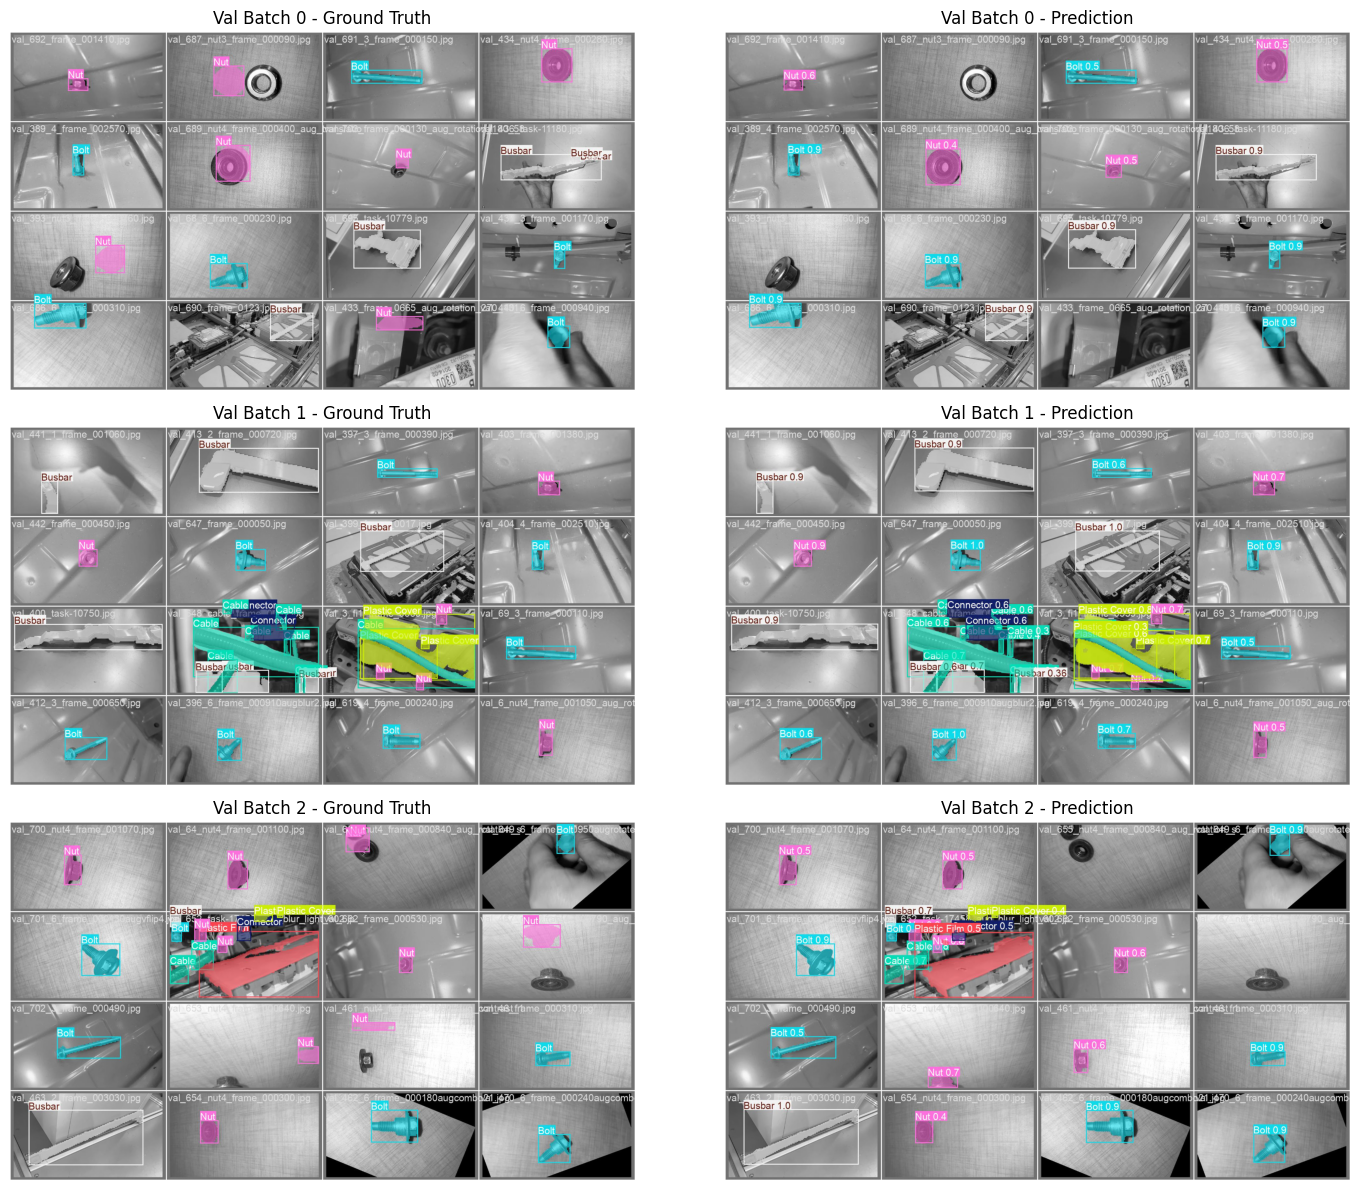

In [ ]:
# Image file paths 
val_batches = [0, 1, 2]
base_path = "/kaggle/working/runs/segment/train2/"

plt.figure(figsize=(15, 12))

for i, batch in enumerate(val_batches):
    label_path = f"{base_path}val_batch{batch}_labels.jpg"
    pred_path = f"{base_path}val_batch{batch}_pred.jpg"
    
    # Show labels
    plt.subplot(3, 2, i * 2 + 1)
    plt.imshow(mpimg.imread(label_path))
    plt.title(f"Val Batch {batch} - Ground Truth")
    plt.axis('off')

    # Show predictions
    plt.subplot(3, 2, i * 2 + 2)
    plt.imshow(mpimg.imread(pred_path))
    plt.title(f"Val Batch {batch} - Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Run model on Testing Set

🔍 Predicting on the following images:
- test_1018_fi1_frame_0564_aug_scale_up_65.jpg
- test_101_2_frame_001190.jpg
- test_1020_3_frame_001110.jpg
- test_1021_frame_0079.jpg
- test_1026_frame_000440.jpg
- test_1027_4_frame_003020.jpg
- test_102_1_frame_001050.jpg
- test_1032_3_frame_0100.jpg

0: 640x640 2 Busbars, 3 Nuts, 14.2ms
1: 640x640 3 Busbars, 14.2ms
2: 640x640 2 Bolts, 14.2ms
3: 640x640 3 Busbars, 14.2ms
4: 640x640 1 Nut, 14.2ms
5: 640x640 1 Bolt, 14.2ms
6: 640x640 1 Busbar, 14.2ms
7: 640x640 1 Connector, 14.2ms


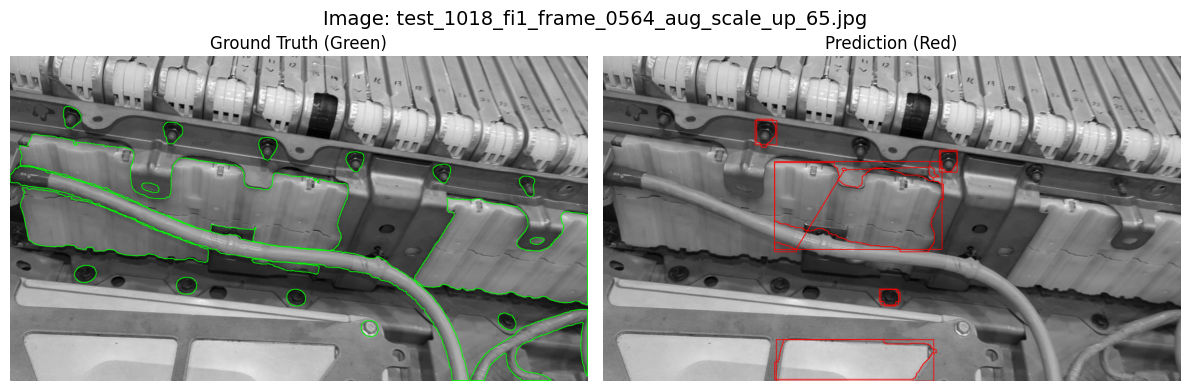

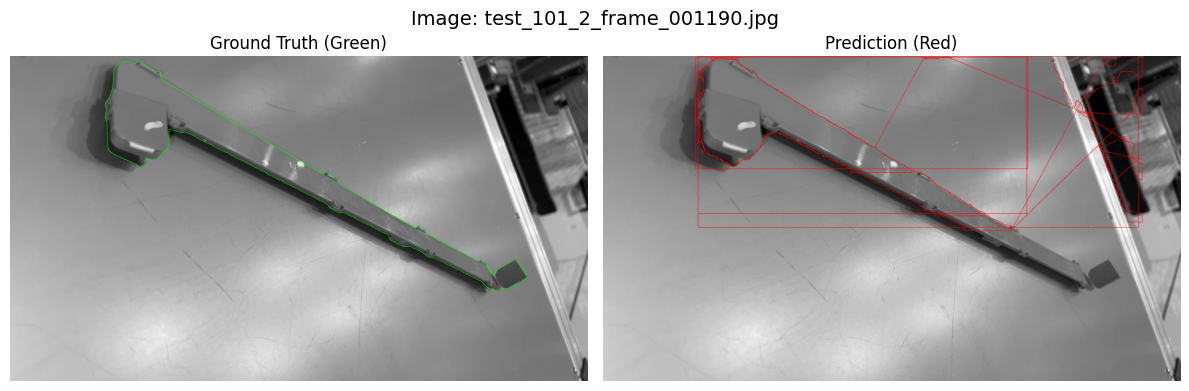

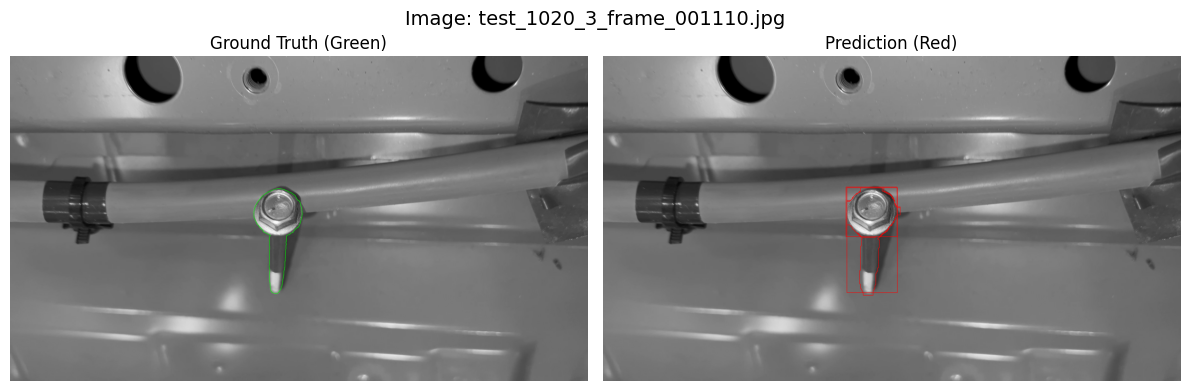

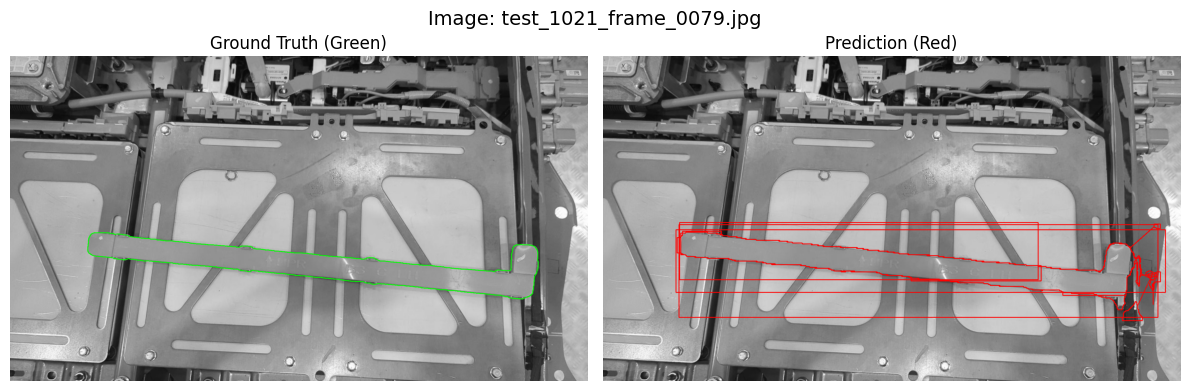

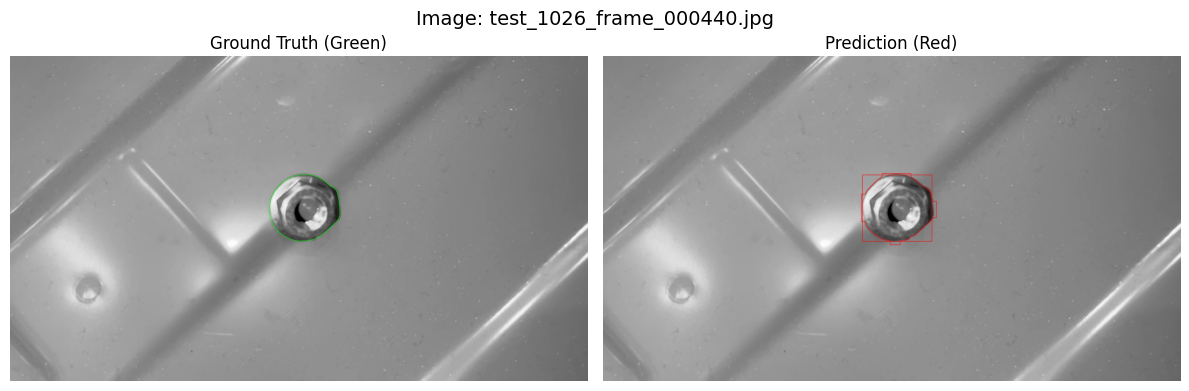

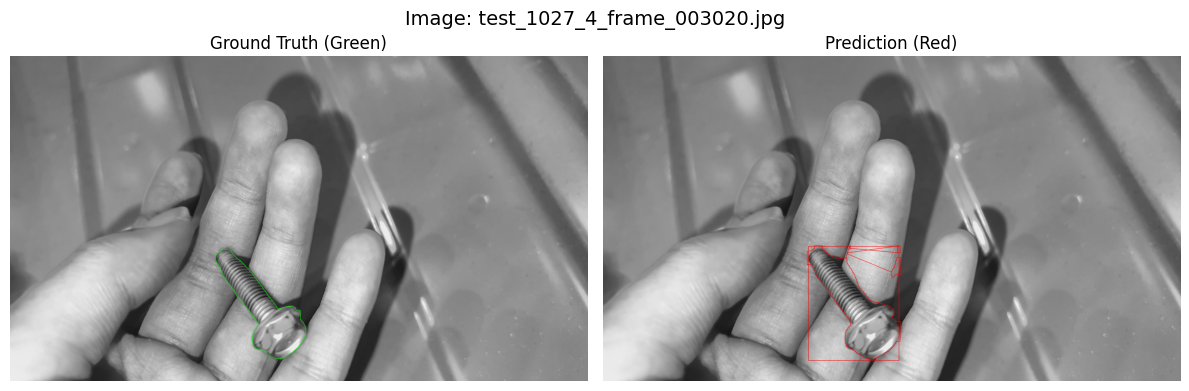

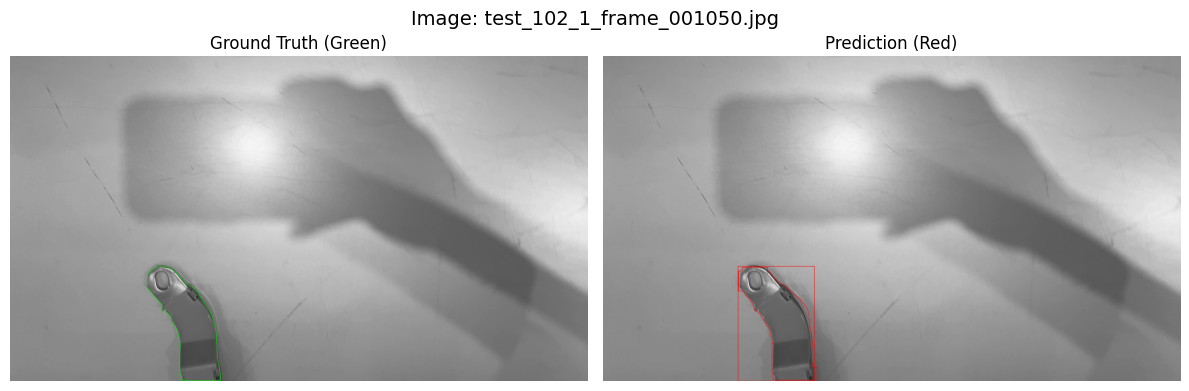

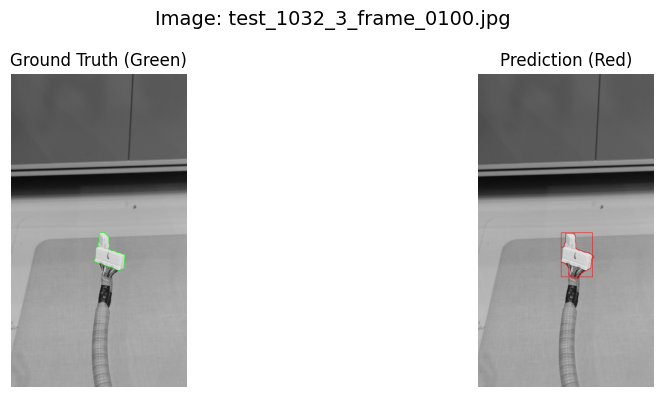

Speed: 2.4ms preprocess, 14.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
# Load trained YOLOv8 model 
model = YOLO("/kaggle/working/runs/segment/train/weights/best.pt")

# Get first 10 test images 
test_image_dir = Path("/kaggle/working/yolo_dataset/images/test")
label_dir = Path("/kaggle/working/yolo_dataset/labels/test")

all_images = sorted(test_image_dir.glob("*.jpg"))
selected_indices = [20, 22, 23, 24, 28,29, 32, 35]  
image_paths = [all_images[i] for i in selected_indices]

print("🔍 Predicting on the following images:")
for p in image_paths:
    print("-", p.name)
# Run inference on first 10 test images 
results = model.predict(source=image_paths, save=False, stream=True)

# Visualize predictions and ground truth 
for i, result in enumerate(results):
    img_path = image_paths[i]
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Ground truth 
    label_path = label_dir / (img_path.stem + ".txt")
    img_gt = img.copy()
    
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls_id = int(parts[0])
                coords = np.array(parts[1:], dtype=float)

                if len(coords) == 4:  # Bounding box
                    x_center, y_center, box_w, box_h = coords
                    x1 = int((x_center - box_w / 2) * w)
                    y1 = int((y_center - box_h / 2) * h)
                    x2 = int((x_center + box_w / 2) * w)
                    y2 = int((y_center + box_h / 2) * h)
                    cv2.rectangle(img_gt, (x1, y1), (x2, y2), (0, 255, 0), 2)
                else:  # Polygon segmentation
                    points = coords.reshape(-1, 2)
                    points[:, 0] *= w
                    points[:, 1] *= h
                    cv2.polylines(img_gt, [np.int32(points)], isClosed=True, color=(0, 255, 0), thickness=2)

    # Predicted 
    img_pred = img.copy()
    
    # Draw predicted boxes
    if result.boxes is not None:
        for box, cls_id in zip(result.boxes.xyxy, result.boxes.cls):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_pred, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Draw predicted masks
    if result.masks:
        for mask in result.masks.xy:
            cv2.polylines(img_pred, [np.int32(mask)], isClosed=True, color=(255, 0, 0), thickness=2)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Image: {img_path.name}", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.imshow(img_gt)
    plt.title("Ground Truth (Green)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_pred)
    plt.title("Prediction (Red)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

🔍 Predicting on the following images:
- test_1050_frame_0094.jpg
- test_1054_6_frame_000480.jpg
- test_1055_2_frame_000980.jpg
- test_1059_frame_000450.jpg
- test_1061_task-10829.jpg
- test_1063_4_frame_0025.jpg
- test_1069_frame_001160.jpg
- test_1070_frame_001390.jpg

0: 640x640 1 Cable, 1 Connector, 12.9ms
1: 640x640 1 Bolt, 12.9ms
2: 640x640 (no detections), 12.9ms
3: 640x640 1 Bolt, 12.9ms
4: 640x640 3 Busbars, 12.9ms
5: 640x640 1 Connector, 12.9ms
6: 640x640 1 Nut, 12.9ms
7: 640x640 1 Nut, 12.9ms


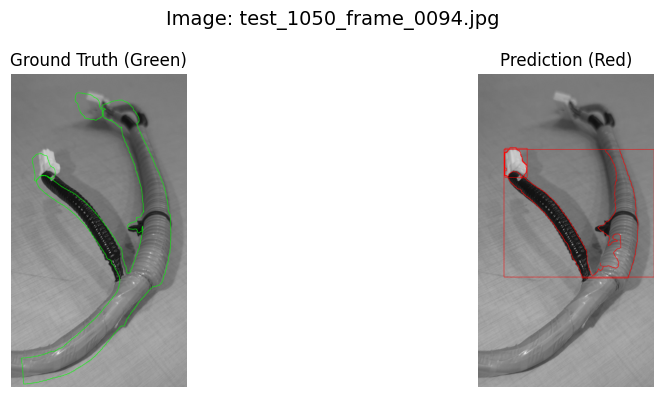

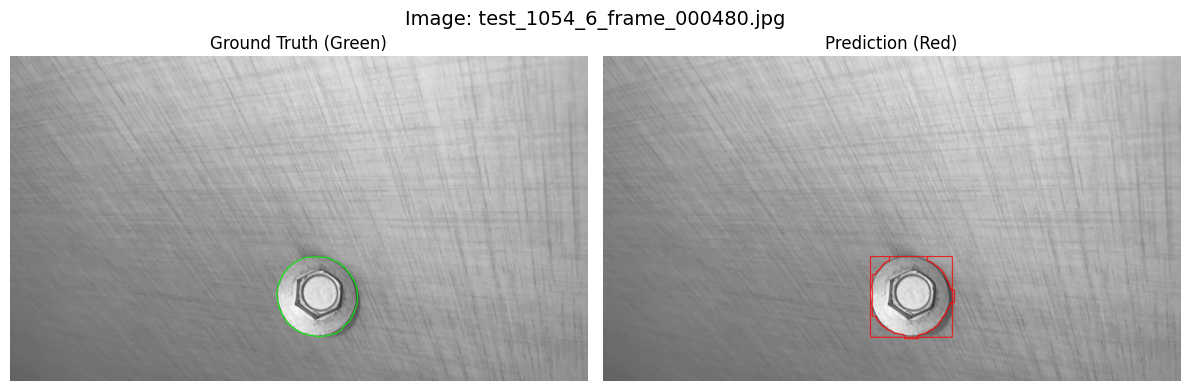

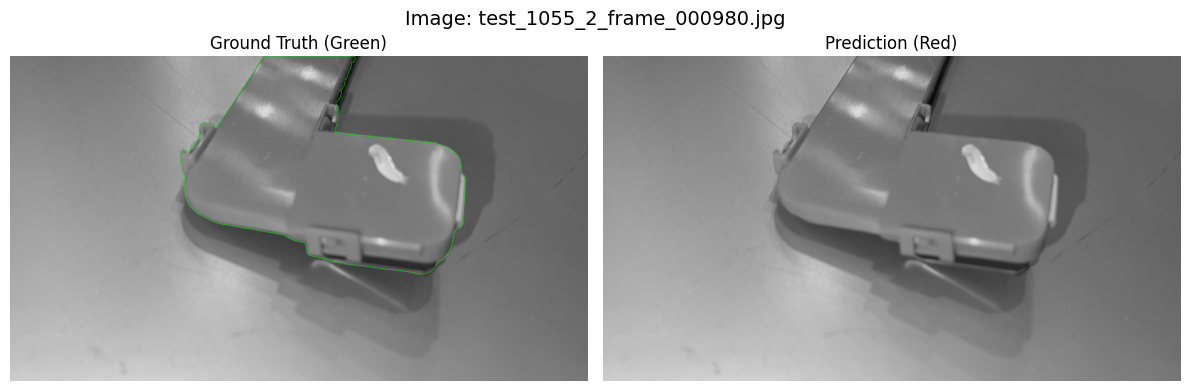

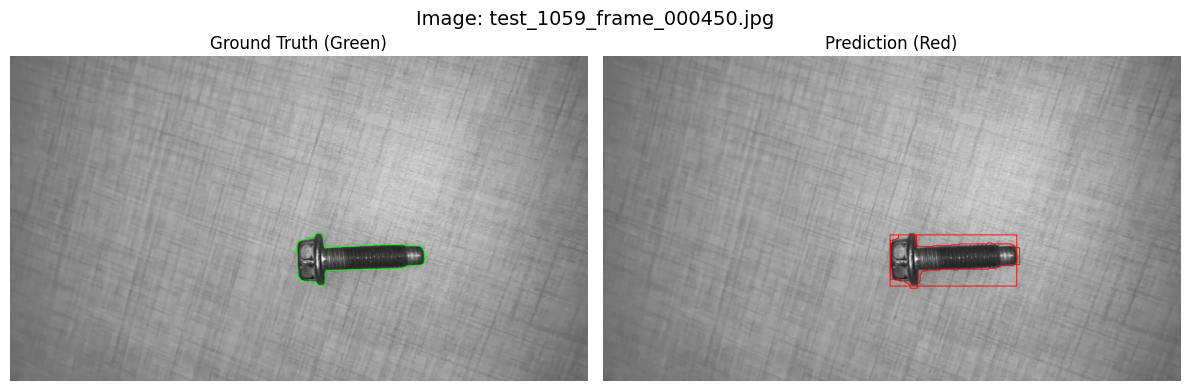

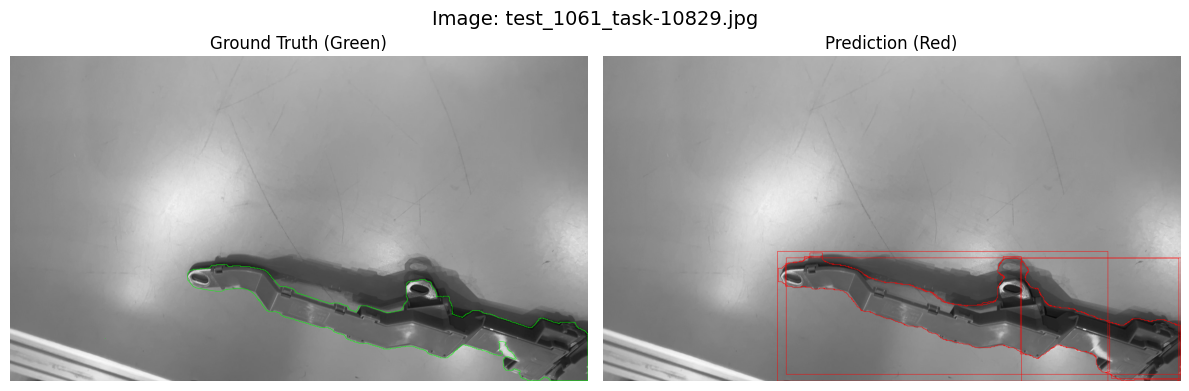

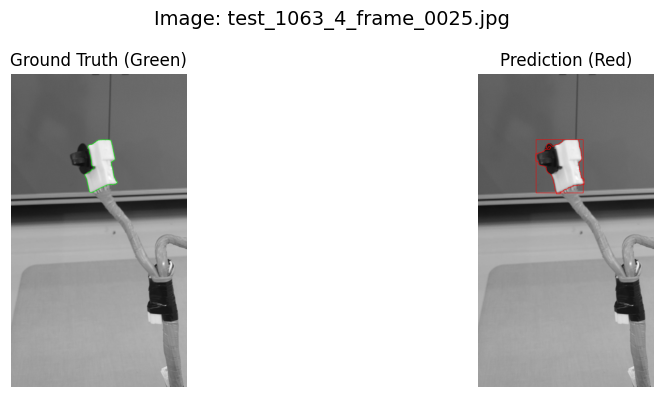

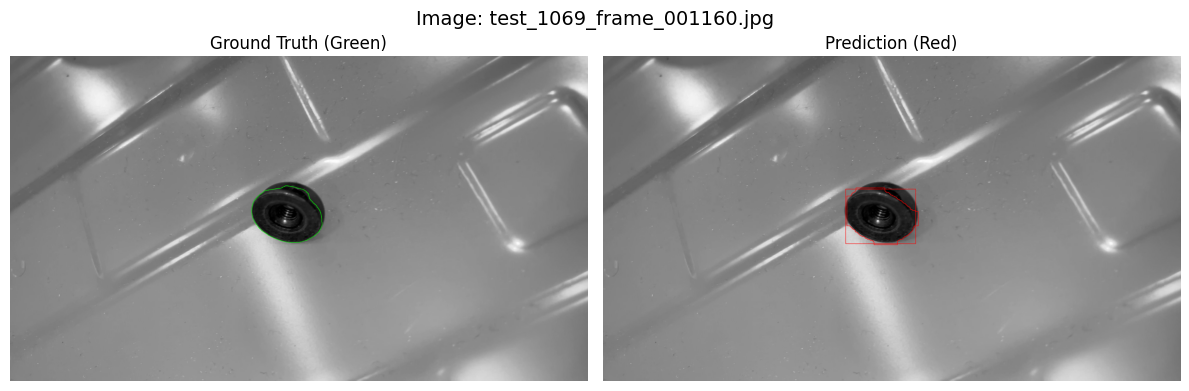

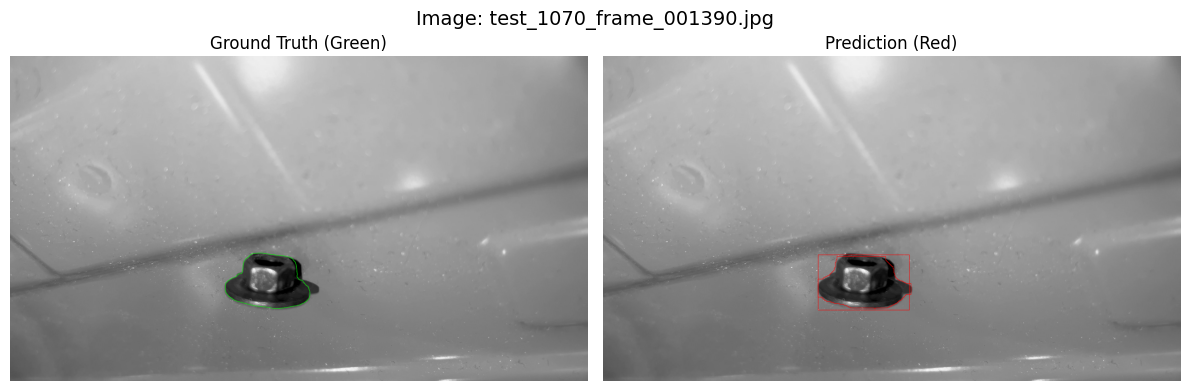

Speed: 2.5ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
# Load trained YOLOv8 model 
model = YOLO("/kaggle/working/runs/segment/train/weights/best.pt")

# Get first 10 test images 
test_image_dir = Path("/kaggle/working/yolo_dataset/images/test")
label_dir = Path("/kaggle/working/yolo_dataset/labels/test")

all_images = sorted(test_image_dir.glob("*.jpg"))
selected_indices = [55, 59, 60, 64, 67, 69, 75, 77]
image_paths = [all_images[i] for i in selected_indices]

print("🔍 Predicting on the following images:")
for p in image_paths:
    print("-", p.name)
# Run inference on first 10 test images 
results = model.predict(source=image_paths, save=False, stream=True)

# Visualize predictions and ground truth 
for i, result in enumerate(results):
    img_path = image_paths[i]
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Ground truth 
    label_path = label_dir / (img_path.stem + ".txt")
    img_gt = img.copy()
    
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls_id = int(parts[0])
                coords = np.array(parts[1:], dtype=float)

                if len(coords) == 4:  # Bounding box
                    x_center, y_center, box_w, box_h = coords
                    x1 = int((x_center - box_w / 2) * w)
                    y1 = int((y_center - box_h / 2) * h)
                    x2 = int((x_center + box_w / 2) * w)
                    y2 = int((y_center + box_h / 2) * h)
                    cv2.rectangle(img_gt, (x1, y1), (x2, y2), (0, 255, 0), 2)
                else:  # Polygon segmentation
                    points = coords.reshape(-1, 2)
                    points[:, 0] *= w
                    points[:, 1] *= h
                    cv2.polylines(img_gt, [np.int32(points)], isClosed=True, color=(0, 255, 0), thickness=2)

    # Predicted 
    img_pred = img.copy()
    
    # Draw predicted boxes
    if result.boxes is not None:
        for box, cls_id in zip(result.boxes.xyxy, result.boxes.cls):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_pred, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Draw predicted masks
    if result.masks:
        for mask in result.masks.xy:
            cv2.polylines(img_pred, [np.int32(mask)], isClosed=True, color=(255, 0, 0), thickness=2)

    # Plot
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Image: {img_path.name}", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.imshow(img_gt)
    plt.title("Ground Truth (Green)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_pred)
    plt.title("Prediction (Red)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()